# Casimir forces with the graphene family + magnetic field

## 1 - Graphene family magneto-optical response

In [149]:
#Importing libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d

#Defining paths
path_conductivities = 'conductivities'
path_casimir = 'casimirenergies'
path_phasediagrams = 'casimirphasediagram'

In [2]:
#Zero-temperature DC conductivity.
def sigmaDC_xy(elE,Lambda,EB,mu):
    sigmaxy_dc = 0
    for eta in (-1,1):
        for s in (-1,1):
            Gap = -eta*s + elE + eta*Lambda
            sigmaxy_dc += -(2*np.sign(mu)*np.heaviside(mu**2 - Gap**2,1)*np.int((mu**2 - Gap**2)/(EB**2)) - np.sign(-eta*Gap - mu))/np.pi
            
    return sigmaxy_dc

#Full expressions for the local conductivity independent components (sigma_xx and sigma_xy).
#This function can be used to calculate the conductivity for an array of frequencies (vectorized implementation).
#The number of terms that must be added for a good convergence at imaginary frequencies 
#depends on the magnetic field, as explored in previous versions of this notebook.
def sigma_xx_xy(E_freq,E_dis,elE,Lambda,EB,kbT,mu):
    sumxx = 0
    sumxy = 0
    for eta in (-1,1):
        for s in (-1,1):
            Gap = -eta*s + elE + eta*Lambda
            for m in range(-int(20000*EB**-2),int(20001*EB**-2)):
                for n in set([-m - 1, -m + 1, m - 1, m + 1]):
                    if n == 0:
                        Energyn =  -eta*Gap
                        Anp = (1 - eta)/2
                        Anm = (1 + eta)/2
                    else:
                        Energyn = np.sign(n)*np.sqrt(Gap**2 + np.absolute(n)*(EB**2))
                        Anp = np.sqrt((np.sign(n)*Gap + np.absolute(Energyn))/(2*np.absolute(Energyn)))
                        Anm = np.sqrt((-np.sign(n)*Gap + np.absolute(Energyn))/(2*np.absolute(Energyn)))
                    if m == 0:
                        Energym =  -eta*Gap
                        Amp = (1 - eta)/2
                        Amm = (1 + eta)/2
                    else:
                        Energym = np.sign(m)*np.sqrt(Gap**2 + np.absolute(m)*(EB**2))
                        Amp = np.sqrt((np.sign(m)*Gap + np.absolute(Energym))/(2*np.absolute(Energym)))
                        Amm = np.sqrt((-np.sign(m)*Gap + np.absolute(Energym))/(2*np.absolute(Energym)))
                    if kbT == 0:
                        f_dn = np.heaviside(mu - Energyn,1)
                        f_dm = np.heaviside(mu - Energym,1)
                    else:
                        f_dn = 1/(np.exp((Energyn - mu)/kbT) + 1)
                        f_dm = 1/(np.exp((Energym - mu)/kbT) + 1)  
                    if np.absolute(n) == (np.absolute(m) + eta):
                        deltap = 1
                    else:
                        deltap = 0
                    if np.absolute(n) == (np.absolute(m) - eta):
                        deltam = 1
                    else:
                        deltam = 0
                    df = f_dm - f_dn
                    dE = Energyn - Energym
                    num1 = (EB**2)*df*deltap*((Amm*Anp)**2)
                    num2 = (EB**2)*df*deltam*((Amp*Anm)**2)
                    den = np.pi*dE*(E_freq - dE + 1j*E_dis)
                    sumxx += (num1*1j + num2*1j)/den
                    sumxy += eta*(num1 - num2)/den
                    
    return np.array([sumxx,sumxy])

## N.B.: all the parameters are normalized by the spin-orbit coupling lambda_SO. The conductivity is normalized by sigma_0.

Let's take a look at the functions defined above, starting by the phase diagram generated by the DC Hall conductivity and then plotting the real frequency-dependent Hall conductivity.

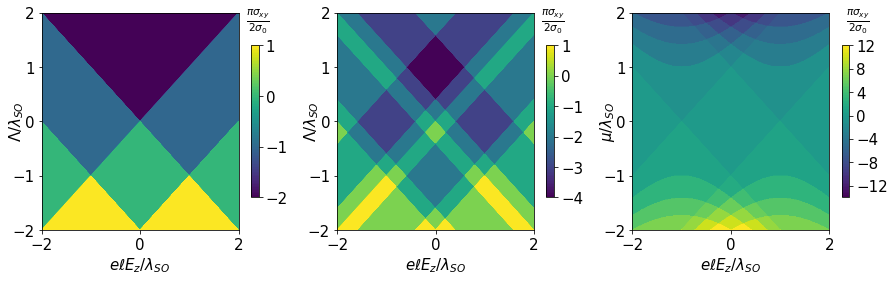

In [3]:
#Generating the relevant arrays for the contour plot.
x = np.arange(-2, 2.01, 0.01)
y = np.copy(x)
z1 = np.pi*np.array([sigmaDC_xy(elE,Lambda,1.2,1) for Lambda in x for elE in y])/2
z2 = np.pi*np.array([sigmaDC_xy(elE,Lambda,0.8,1) for Lambda in x for elE in y])/2
z3 = np.pi*np.array([sigmaDC_xy(elE,0,1,mu) for mu in x for elE in y])/2
Z1 = z1.reshape(x.size,y.size)
Z2 = z2.reshape(x.size,y.size)
Z3 = z3.reshape(x.size,y.size)

#Plotting the DC conductivities
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(15, 4),nrows=1, ncols=3)

c0 = ax[0].contourf(x, y, Z1,np.linspace(Z1.min(), Z1.max(),100))
b0 = fig.colorbar(c0,ax=ax[0],ticks=range(-2,2,1), shrink=0.7)
b0.set_label(r'$\frac{\pi\sigma_{xy}}{2\sigma_0}$', labelpad=-30, y=1.25, rotation=0)
ax[0].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[0].set_ylabel("$\Lambda/\lambda_{SO}$")
ax[0].yaxis.set_label_coords(-0.08,0.5)

c1 = ax[1].contourf(x, y, Z2,np.linspace(Z2.min(), Z2.max(),100))
b1 = fig.colorbar(c1,ax=ax[1],ticks=range(-4,4,1), shrink=0.7)
b1.set_label(r'$\frac{\pi\sigma_{xy}}{2\sigma_0}$', labelpad=-30, y=1.25, rotation=0)
ax[1].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[1].set_ylabel("$\Lambda/\lambda_{SO}$")
ax[1].yaxis.set_label_coords(-0.08,0.5)

c2 = ax[2].contourf(x, y, Z3,np.linspace(Z3.min(), Z3.max(),100))
b2 = fig.colorbar(c2,ax=ax[2],ticks=range(-16,16,4), shrink=0.7)
b2.set_label(r'$\frac{\pi\sigma_{xy}}{2\sigma_0}$', labelpad=-30, y=1.25, rotation=0)
ax[2].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[2].set_ylabel("$\mu/\lambda_{SO}$")
ax[2].yaxis.set_label_coords(-0.08,0.5)

plt.show()

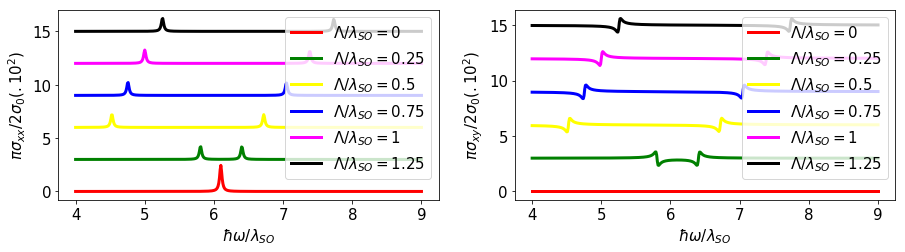

In [4]:
#Plotting the frequency-dependent conductivities
Efreq = np.arange(4,9.01,0.01)
plt.figure(figsize=(15,3.5))

plt.subplot(121)
plt.plot(Efreq,np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0,5,0,0.5)[0])/200,color='red',linewidth=3,label='$\Lambda/\lambda_{SO} = 0$')
plt.plot(Efreq,3 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0.25,5,0,0.5)[0])/200,color='green',linewidth=3,label='$\Lambda/\lambda_{SO} = 0.25$')
plt.plot(Efreq,6 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0.5,5,0,0.5)[0])/200,color='yellow',linewidth=3,label='$\Lambda/\lambda_{SO} = 0.5$')
plt.plot(Efreq,9 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0.75,5,0,0.5)[0])/200,color='blue',linewidth=3,label='$\Lambda/\lambda_{SO} = 0.75$')
plt.plot(Efreq,12 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,1,5,0,0.5)[0])/200,color='magenta',linewidth=3,label='$\Lambda/\lambda_{SO} = 1$')
plt.plot(Efreq,15 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,1.25,5,0,0.5)[0])/200,color='black',linewidth=3,label='$\Lambda/\lambda_{SO} = 1.25$')
plt.xlabel('$\hbar\omega/\lambda_{SO}$')
plt.ylabel('$\pi\sigma_{xx}/2\sigma_0(.10^2)$')
plt.legend(loc="upper right")

plt.subplot(122)
plt.plot(Efreq,np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0,5,0,0.5)[1])/200,color='red',linewidth=3,label='$\Lambda/\lambda_{SO} = 0$')
plt.plot(Efreq,3 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0.25,5,0,0.5)[1])/200,color='green',linewidth=3,label='$\Lambda/\lambda_{SO} = 0.25$')
plt.plot(Efreq,6 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0.5,5,0,0.5)[1])/200,color='yellow',linewidth=3,label='$\Lambda/\lambda_{SO} = 0.5$')
plt.plot(Efreq,9 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,0.75,5,0,0.5)[1])/200,color='blue',linewidth=3,label='$\Lambda/\lambda_{SO} = 0.75$')
plt.plot(Efreq,12 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,1,5,0,0.5)[1])/200,color='magenta',linewidth=3,label='$\Lambda/\lambda_{SO} = 1$')
plt.plot(Efreq,15 + np.pi*np.real(sigma_xx_xy(Efreq,0.02,0,1.25,5,0,0.5)[1])/200,color='black',linewidth=3,label='$\Lambda/\lambda_{SO} = 1.25$')
plt.xlabel('$\hbar\omega/\lambda_{SO}$')
plt.ylabel('$\pi\sigma_{xy}/2\sigma_0(.10^2)$')
plt.legend(loc="upper right")

plt.show()

### 1.1 - Saving the conductivites in the ".npy" file format

Since it takes some minutes to compute the frequency-dependent conductivity, it is important to save the numpy arrays for further computation.

In [4]:
#Saving the conductivities for the (E_z,Lambda) phase diagram with mu < EB
elE = np.arange(0,2.01,0.05)
Lambda = np.arange(-2,2.025,0.05)

for i in range (0,elE.size):
    for j in range(0,Lambda.size):
        np.save(os.path.join(path_conductivities,\
        'G=0Ez='+str(round(elE[i],3))+'L='+str(round(Lambda[j],3))+'EB=1.2T=0mu=1.npy'),\
        np.real(sigma_xx_xy(np.append(np.arange(0,10,0.01)*1j,np.arange(10.1,100,0.1)*1j),0,round(elE[i],3),\
        round(Lambda[j],3),1.2,0,1)).astype('float32'))


In [ ]:
#Saving the conductivities for the (E_z,Lambda) phase diagram with mu > EB
elE = np.arange(0,2.01,0.05)
Lambda = np.arange(-2,2.025,0.05)

for i in range (0,elE.size):
    for j in range(0,Lambda.size):
        np.save(os.path.join(path_conductivities,\
        'G=0Ez='+str(round(elE[i],3))+'L='+str(round(Lambda[j],3))+'EB=0.8T=0mu=1.npy'),\
        np.real(sigma_xx_xy(np.append(np.arange(0,10,0.01)*1j,np.arange(10.1,100,0.1)*1j),0,round(elE[i],3),\
        round(Lambda[j],3),0.8,0,1)).astype('float32'))

In [ ]:
#Saving the conductivities for the (E_z,mu) phase diagrame with Lambda = 0.
elE = np.arange(0,2.01,0.05)
mu = np.arange(-2,2.025,0.05)

for i in range (0,elE.size):
    for j in range(0,mu.size):
        np.save(os.path.join(path_conductivities,\
        'G=0Ez='+str(round(elE[i],3))+'L=0EB=1T=0mu='+str(round(mu[j],3))+'.npy'),\
        np.real(sigma_xx_xy(np.append(np.arange(0,10,0.01)*1j,np.arange(10.1,100,0.1)*1j),0,round(elE[i],3),\
        0,1,0,mu[j])).astype('float32'))


## 2 - Zero-Temperature Casimir force

In [3]:
#Defining some important constants
hbar = (6.62607*10**(-34))/(2*np.pi)
e = 1.602177*10**(-19)
epsilon_0 = 8.85419*10**(-12)
mu_0 = 4*np.pi*10**(-7)
c = np.sqrt(1/(epsilon_0*mu_0))
alpha = e**2/(4*np.pi*epsilon_0*hbar*c)
sigma0 = alpha*c/4

### 2.1 - Lifshitz formula for two identical materials

In [4]:
# Casimier energy normalized by the graphene-graphene Casimir energy in the long-distance regime
def ECasgf(a,E_dis,elE,Lambda,EB,mu):
    csi = np.append(np.arange(np.finfo(float).eps,0.01/a,0.00001/a),np.arange(0.01/a,6/a,0.001/a))
    sigmaxx = sigma0*np.interp(csi,np.append(np.arange(0,10,0.01),np.arange(10.1,100,0.1)),np.real(np.load(os.path.join(path_conductivities, 'G='+str(E_dis)+'Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T=0mu='+str(mu)+'.npy'))[0]))
    sigmaxy = sigma0*np.interp(csi,np.append(np.append(np.arange(0,10,0.01),np.arange(10.1,100,0.1)),200),np.append(np.real(np.load(os.path.join(path_conductivities, 'G='+str(E_dis)+'Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T=0mu='+str(mu)+'.npy'))[1]),0))
    csi_integral = np.zeros(csi.size)
    for i in range(0,csi.size):
        kcsi = np.sqrt(csi[i]**2 + csi**2)/csi
        delta = 1 + 2*np.pi*sigmaxx*(kcsi + 1/kcsi)/c + (sigmaxx**2 + sigmaxy**2)*(2*np.pi/c)**2
        Rss = -(2*np.pi/(c*delta))*(sigmaxx/kcsi + (2*np.pi/c)*(sigmaxx**2 + sigmaxy**2))
        Rsp = 2*np.pi*sigmaxy/(c*delta)
        Rpp = (2*np.pi/(c*delta))*(sigmaxx*kcsi + (2*np.pi/c)*(sigmaxx**2 + sigmaxy**2))
        det = (1 - (Rss**2 - Rsp**2)*np.exp(-2*np.sqrt(csi[i]**2 + csi**2)*a))*(1 - (Rpp**2 - Rsp**2)*np.exp(-2*np.sqrt(csi[i]**2 + csi**2)*a)) + ((Rss*Rsp - Rsp*Rpp)*np.exp(-2*np.sqrt(csi[i]**2 + csi**2)*a))**2
        integrand = csi[i]*np.log(det)
        csi_integral[i] = integrate.simps(integrand,csi)        
    integral = integrate.simps(csi_integral,csi)
    return -(8*a**3)*integral/(np.pi*alpha)

### 2.2 Approximated expressions in the long-distance regime

In [5]:
#Case C1 = C2 = 0 without dissipation
def E00(a,elE,Lambda,EB,mu):
    Dsigmaxx = 100*sigma0*np.real(np.load(os.path.join(path_conductivities, 'G=0Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T=0mu='+str(mu)+'.npy'))[0,1])
    num = 144*np.pi*Dsigmaxx**2
    den = 5*alpha*(a*c)**2
    return num/den

#First correction due to dissipation
def DeltaE00(a,E_dis,elE,Lambda,EB,mu):
    Dsigmaxx = 100*sigma0*np.real(np.load(os.path.join(path_conductivities, 'G=0Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T=0mu='+str(mu)+'.npy'))[0,1])
    num = 4*E_dis*Dsigmaxx
    den = alpha*c
    array = np.zeros(a.size)
    array += num/den
    return array

### 2.3 Saving the casimir energies in the '.npy' file format

In [ ]:
#Saving the Casimir energies for the (E_z,Lambda) phase diagram with mu < EB
elE = np.arange(0,2.01,0.05)
Lambda = np.arange(-2,2.025,0.05)

for i in range (0,elE.size):
    E = np.zeros(Lambda.size)
    for j in range(0,Lambda.size):
        E[j] = ECasgf(10,0,round(elE[i],3),round(Lambda[j],3),1.2,1)
    np.save(os.path.join(path_phasediagrams,'a=10G=0Ez='+str(round(elE[i],3))+'EB=0.8T=0mu=1.npy'),E)

In [ ]:
#Saving the Casimir energies for the (E_z,Lambda) phase diagram with mu > EB
elE = np.arange(0,2.01,0.05)
Lambda = np.arange(-2,2.025,0.05)

for i in range (0,elE.size):
    E = np.zeros(Lambda.size)
    for j in range(0,Lambda.size):
        E[j] = ECasgf(10,0,round(elE[i],3),round(Lambda[j],3),0.8,1)
    np.save(os.path.join(path_phasediagrams,'a=10G=0Ez='+str(round(elE[i],3))+'EB=0.8T=0mu=1.npy'),E)

In [ ]:
#Saving the Casimir energies for the (E_z,mu) phase diagram with Lambda = 0
elE = np.arange(0,2.01,0.05)
mu = np.arange(-2,2.025,0.05)

for i in range (0,elE.size):
    E = np.zeros(mu.size)
    for j in range(0,mu.size):
        E[j] = ECasgf(10,0,round(elE[i],3),0,1,round(mu[j],3))
    np.save(os.path.join(path_phasediagrams,'a=10G=0Ez='+str(round(elE[i],3))+'L=0EB=1T=0.npy'),E)

In [119]:
#Saving the conductivities with non-zero dissipation
np.save(os.path.join(path_conductivities,\
        'G=0.02Ez=1.0L=0EB=1T=0mu=1.25.npy'),\
        np.real(sigma_xx_xy(np.append(np.arange(0,10,0.01)*1j,np.arange(10.1,100,0.1)*1j),0.02,1,\
       0,1,0,1.25)).astype('float32'))
    
np.save(os.path.join(path_conductivities,\
        'G=0.03Ez=1.0L=0EB=1T=0mu=1.25.npy'),\
        np.real(sigma_xx_xy(np.append(np.arange(0,10,0.01)*1j,np.arange(10.1,100,0.1)*1j),0.03,1,\
       0,1,0,1.25)).astype('float32'))

In [120]:
a = np.append(np.arange(0.01,1,0.05),np.arange(1,20.1,0.5))
E1 = np.zeros(a.size)
E2 = np.copy(E1)
E3 = np.copy(E1)
E4 = np.copy(E1)
E5 = np.copy(E1)
E6 = np.copy(E1)

#Casimir energy varying the distance between the plates
for i in range(0,a.size):
    E1[i] =  ECasgf(a[i],0,1.0,0,1,0.5)
    E2[i] =  ECasgf(a[i],0,1.0,0,1,1.25)
    E3[i] =  ECasgf(a[i],0.01,1.0,0,1,1.25)
    E4[i] =  ECasgf(a[i],0.02,1.0,0,1,1.25)
    E5[i] =  ECasgf(a[i],0.03,1.0,0,1,1.25)
    E6[i] =  ECasgf(a[i],0,1.0,0,1,1.5)
    
np.save(os.path.join(path_casimir, 'G=0Ez=1.0L=0EB=1T=0mu=0.5.npy'),E1)
np.save(os.path.join(path_casimir, 'G=0Ez=1.0L=0EB=1T=0mu=1.25.npy'),E2)
np.save(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0mu=1.25.npy'),E3)
np.save(os.path.join(path_casimir, 'G=0.02Ez=1.0L=0EB=1T=0mu=1.25.npy'),E4)
np.save(os.path.join(path_casimir, 'G=0.03Ez=1.0L=0EB=1T=0mu=1.25.npy'),E5)
np.save(os.path.join(path_casimir, 'G=0Ez=1.0L=0EB=1T=0mu=1.5.npy'),E6)

### 2.4 Phase diagrams

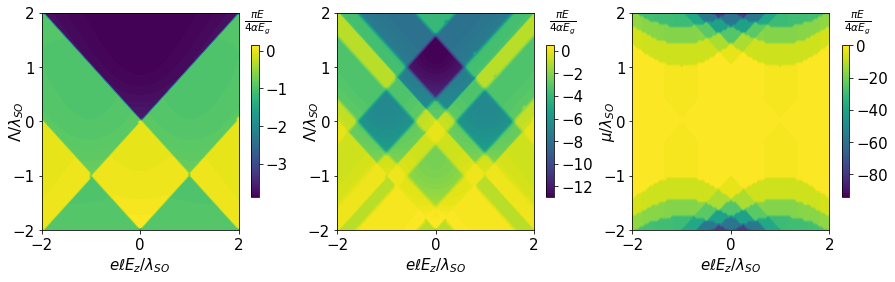

In [10]:
x = np.arange(-2.0, 2.025, 0.05)
y = np.copy(x)
z1 = np.array([np.pi*np.load(os.path.join(path_phasediagrams, 'a=10G=0Ez='+str(round(np.absolute(elE),3))+'EB=1.2T=0mu=1.npy'))[i]/(4*alpha) for i in range(0,x.size) for elE in y])
z2 = np.array([np.pi*np.load(os.path.join(path_phasediagrams, 'a=10G=0Ez='+str(round(np.absolute(elE),3))+'EB=0.8T=0mu=1.npy'))[i]/(4*alpha) for i in range(0,x.size) for elE in y])
z3 = np.array([np.pi*np.load(os.path.join(path_phasediagrams, 'a=10G=0Ez='+str(round(np.absolute(elE),3))+'L=0EB=1T=0.npy'))[i]/(4*alpha) for i in range(0,x.size) for elE in y])
Z1 = z1.reshape(x.size,y.size)
Z2 = z2.reshape(x.size,y.size)
Z3 = z3.reshape(x.size,y.size)

#Improving the sharpness near the boundaries of the phase diagrams
for i in range(0,x.size):
    Z1[i,i] = Z1[i,i-1]
    Z2[i,i] = Z2[i,i-1]
    Z1[i,-i + 80] = Z1[i-1,-i + 80]
    Z2[i,-i + 80] = Z2[i-1,-i + 80]
    Z1[i,-i + 40] = Z1[i-1,-i + 40]
    Z2[i,-i + 40] = Z2[i-1,-i + 40]
    if i + 40 < x.size:
        Z1[i,i + 40] = Z1[i-1,i + 40]
        Z2[i,i + 40] = Z2[i-1,i + 40]
        
        
for i in range(0,x.size):
    if i + 20 < x.size:
        Z3[i,i + 20] = Z3[i-1,i + 20]
    if i - 20 >= 0:
        Z3[i,i - 20] = Z3[i-1,i - 20]
    if -i + 60 > 0:
        Z3[i,-i + 60] = Z3[i-1,-i + 60]
    if -i + 100 < x.size:
        Z3[i,-i + 100] = Z3[i-1,-i + 100]
        


#Plotting the phase diagrams
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(15, 4),nrows=1, ncols=3)

c0 = ax[0].contourf(x, y, Z1,np.linspace(Z1.min(), Z1.max(),100))
b0 = fig.colorbar(c0,ax=ax[0],ticks=range(-4,1,1), shrink=0.7)
b0.set_label(r'$\frac{\pi E}{4\alpha E_g}$', labelpad=-30, y=1.25, rotation=0)
ax[0].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[0].set_ylabel("$\Lambda/\lambda_{SO}$")
ax[0].yaxis.set_label_coords(-0.08,0.5)

c1 = ax[1].contourf(x, y, Z2,np.linspace(Z2.min(), Z2.max(),100))
b1 = fig.colorbar(c1,ax=ax[1],ticks=range(-16,1,2), shrink=0.7)
b1.set_label(r'$\frac{\pi E}{4\alpha E_g}$', labelpad=-30, y=1.25, rotation=0)
ax[1].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[1].set_ylabel("$\Lambda/\lambda_{SO}$")
ax[1].yaxis.set_label_coords(-0.08,0.5)

c2 = ax[2].contourf(x, y, Z3,np.linspace(Z3.min(), Z3.max(),100))
b2 = fig.colorbar(c2,ax=ax[2],ticks=range(-100,40,20), shrink=0.7)
b2.set_label(r'$\frac{\pi E}{4\alpha E_g}$', labelpad=-30, y=1.25, rotation=0)
ax[2].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[2].set_ylabel("$\mu/\lambda_{SO}$")
ax[2].yaxis.set_label_coords(-0.08,0.5)

plt.show()

The scale of the plots above is not very good. Let's plot the square root of the Casimir energy instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


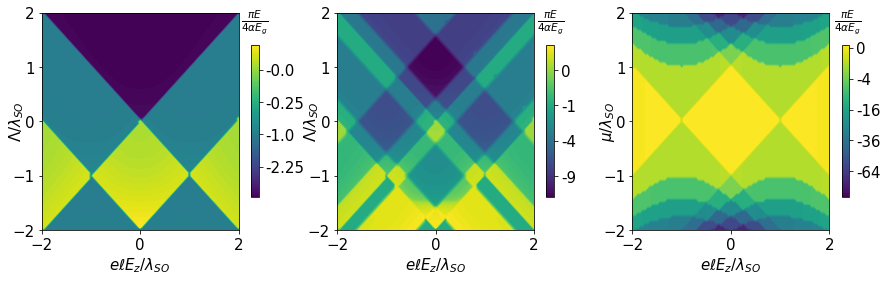

In [24]:
Z1sqrt = np.where(Z1 < 0, -np.sqrt(-Z1), np.sqrt(Z1))
Z2sqrt = np.where(Z2 < 0, -np.sqrt(-Z2), np.sqrt(Z2))
Z3sqrt = np.where(Z3 < 0, -np.sqrt(-Z3), np.sqrt(Z3))

#Plotting the phase diagrams in a quadratic scale
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(15, 4),nrows=1, ncols=3)

c0 = ax[0].contourf(x, y, Z1sqrt,np.linspace(Z1sqrt.min(), Z1sqrt.max(),100))
b0 = fig.colorbar(c0,ax=ax[0],ticks=[0,-0.5,-1,-1.5], shrink=0.7)
b0.set_label(r'$\frac{\pi E}{4\alpha E_g}$', labelpad=-50, y=1.25, rotation=0)
b0.ax.set_yticklabels([-i**2 for i in b0.get_ticks()])
ax[0].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[0].set_ylabel("$\Lambda/\lambda_{SO}$")
ax[0].yaxis.set_label_coords(-0.08,0.5)

c1 = ax[1].contourf(x, y, Z2sqrt,np.linspace(Z2sqrt.min(), Z2sqrt.max(),100))
b1 = fig.colorbar(c1,ax=ax[1],ticks=range(-4,1,1), shrink=0.7)
b1.set_label(r'$\frac{\pi E}{4\alpha E_g}$', labelpad=-25, y=1.25, rotation=0)
b1.ax.set_yticklabels([-i**2 for i in b1.get_ticks()])
ax[1].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[1].set_ylabel("$\Lambda/\lambda_{SO}$")
ax[1].yaxis.set_label_coords(-0.08,0.5)

c2 = ax[2].contourf(x, y, Z3sqrt,np.linspace(Z3sqrt.min(), Z3sqrt.max(),100))
b2 = fig.colorbar(c2,ax=ax[2],ticks=range(-12,4,2), shrink=0.7)
b2.set_label(r'$\frac{\pi E}{4\alpha E_g}$', labelpad=-33, y=1.25, rotation=0)
b2.ax.set_yticklabels([-i**2 for i in b2.get_ticks()])
ax[2].set_xlabel("$e\ell E_z/\lambda_{SO}$")
ax[2].set_ylabel("$\mu/\lambda_{SO}$")
ax[2].yaxis.set_label_coords(-0.08,0.5)

plt.show()

Now the phase diagram for the Casimir energy looks pretty similar to the plots for the Hall conductivity. We can also plot vertical cuts of the (E_z,mu) phase diagram to see Landau level plateaus in a more clear way.

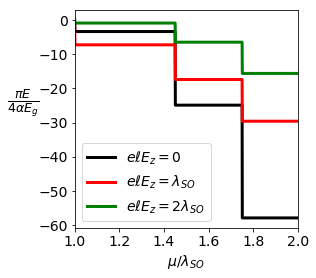

In [67]:
#Vertical cuts of the (E_z,mu) diagram
mu = np.arange(-2.0, 2.025, 0.05)
muinterp = np.arange(-2,2.0,0.001)
E1 = -np.abs(np.pi*np.load(os.path.join(path_phasediagrams, 'a=10G=0Ez=0.0L=0EB=1T=0.npy'))/(4*alpha))
E2 = -np.abs(np.pi*np.load(os.path.join(path_phasediagrams, 'a=10G=0Ez=1.0L=0EB=1T=0.npy'))/(4*alpha))
E3 = -np.abs(np.pi*np.load(os.path.join(path_phasediagrams, 'a=10G=0Ez=2.0L=0EB=1T=0.npy'))/(4*alpha))

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(4,4))
plt.plot(muinterp,interp1d(mu,E1,kind='previous')(muinterp),color='black',linewidth=3,label='$e\ell E_z = 0$')
plt.plot(muinterp,interp1d(mu,E2,kind='previous')(muinterp),color='red',linewidth=3,label='$e\ell E_z = \lambda_{SO}$')
plt.plot(muinterp,interp1d(mu,E3,kind='previous')(muinterp),color='green',linewidth=3,label='$e\ell E_z = 2\lambda_{SO}$')
plt.xlabel('$\mu/\lambda_{SO}$')
plt.ylabel(r'$\frac{\pi E}{4\alpha E_g}$',rotation=0,fontsize=18,labelpad=15)
plt.legend(loc="lower left")
plt.xlim(1,2)


plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


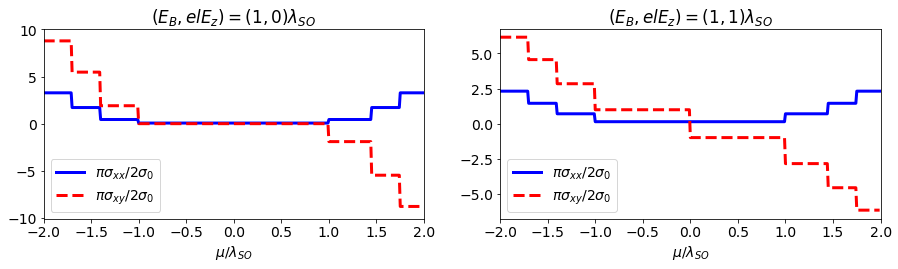

In [56]:
#Low-frequency conductivity as a function of the chemical potential. 
#Answer to why the approximation E ~ C1C2 fails for large mu's.
mu = np.arange(-2,2.01,0.05)
muinterp = np.arange(-2,2,0.01)
sigmaxx1 = np.zeros(mu.size)
sigmaxy1 = np.zeros(mu.size)
sigmaxx2 = np.zeros(mu.size)
sigmaxy2 = np.zeros(mu.size)

for i in range(0,mu.size):
    sigmaxx1[i] = np.load(os.path.join(path_conductivities, 'G=0Ez=0.0L=0EB=1T=0mu='+str(round(mu[i],3))+'.npy'))[0,10]
    sigmaxy1[i] = np.load(os.path.join(path_conductivities, 'G=0Ez=0.0L=0EB=1T=0mu='+str(round(mu[i],3))+'.npy'))[1,10]
    sigmaxx2[i] = np.load(os.path.join(path_conductivities, 'G=0Ez=1.0L=0EB=1T=0mu='+str(round(mu[i],3))+'.npy'))[0,10]
    sigmaxy2[i] = np.load(os.path.join(path_conductivities, 'G=0Ez=1.0L=0EB=1T=0mu='+str(round(mu[i],3))+'.npy'))[1,10]
    
plt.figure(figsize=(15,3.5))

plt.subplot(121)
plt.plot(muinterp,np.pi*interp1d(mu,np.real(sigmaxx1),kind='previous')(muinterp)/2,color='blue',linewidth=3,label='$\pi\sigma_{xx}/2\sigma_0$')
plt.plot(muinterp,np.pi*interp1d(mu,np.real(sigmaxy1),kind='previous')(muinterp)/2,color='red',linestyle='dashed',linewidth=3,label='$\pi\sigma_{xy}/2\sigma_0$')
plt.xlabel('$\mu/\lambda_{SO}$')
plt.legend(loc="lower left")
plt.xlim(-2,2)
plt.ylim(-10.1,10.1)
plt.title("$(E_B,elE_z) = (1,0)\lambda_{SO}$")

plt.subplot(122)
plt.plot(muinterp,np.pi*interp1d(mu,np.real(sigmaxx2),kind='previous')(muinterp)/2,color='blue',linewidth=3,label='$\pi\sigma_{xx}/2\sigma_0$')
plt.plot(muinterp,np.pi*interp1d(mu,np.real(sigmaxy2),kind='previous')(muinterp)/2,color='red',linestyle='dashed',linewidth=3,label='$\pi\sigma_{xy}/2\sigma_0$')
plt.xlabel('$\mu/\lambda_{SO}$')
plt.legend(loc="lower left")
plt.xlim(-2,2)
plt.title("$(E_B,elE_z) = (1,1)\lambda_{SO}$")

plt.show()

These plots for the conductivity show that for high values of the chemical potential the longitudinal component of the conductivity starts to play an important role in the Casimir energy. This explains the fact that the approximation E ~ C_1C_2 is not very good for larger values of mu. The same effect should happen for smaller values of the magnetic field.

### 2.5 Distance dependence of the Casimir energy

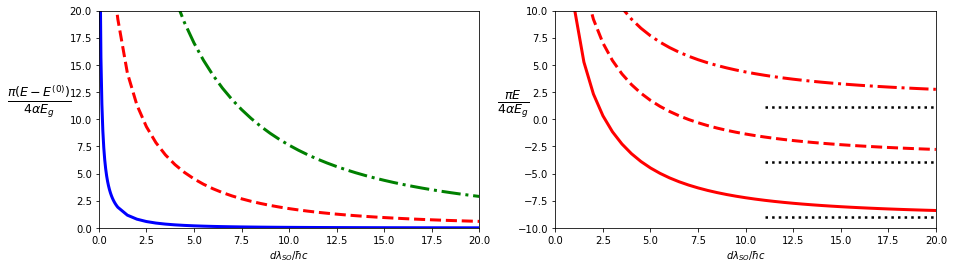

In [6]:
a = np.append(np.arange(0.01,1,0.05),np.arange(1,20.1,0.5))

E1 = np.pi*np.load(os.path.join(path_casimir,'G=0Ez=1.0L=0EB=1T=0mu=0.5.npy'))/(4*alpha)
E2 = np.pi*np.load(os.path.join(path_casimir, 'G=0Ez=1.0L=0EB=1T=0mu=1.25.npy'))/(4*alpha)
E3 = np.pi*np.load(os.path.join(path_casimir, 'G=0Ez=1.0L=0EB=1T=0mu=1.5.npy'))/(4*alpha)
E1a = np.zeros(a.size)
E1a += -(np.pi*np.real(np.load(os.path.join(path_conductivities, 'G=0Ez=1.0L=0EB=1T=0mu=0.5.npy'))[1,0])/2)**2
E2a = np.zeros(a.size)
E2a += -(np.pi*np.real(np.load(os.path.join(path_conductivities, 'G=0Ez=1.0L=0EB=1T=0mu=1.25.npy'))[1,0])/2)**2
E3a = np.zeros(a.size)
E3a += -(np.pi*np.real(np.load(os.path.join(path_conductivities, 'G=0Ez=1.0L=0EB=1T=0mu=1.5.npy'))[1,0])/2)**2

E4 = E2
E4_01 = np.pi*np.load(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0mu=1.25.npy'))/(4*alpha)
E4_02 = np.pi*np.load(os.path.join(path_casimir, 'G=0.02Ez=1.0L=0EB=1T=0mu=1.25.npy'))/(4*alpha)
E4_03 = np.pi*np.load(os.path.join(path_casimir, 'G=0.03Ez=1.0L=0EB=1T=0mu=1.25.npy'))/(4*alpha)
E4a = E2a
E4_01a = E2a + np.pi*DeltaE00(a,0.01,1.0,0,1,1.25)/(4*alpha)
E4_02a = E2a + np.pi*DeltaE00(a,0.02,1.0,0,1,1.25)/(4*alpha)
E4_03a = E2a + np.pi*DeltaE00(a,0.03,1.0,0,1,1.25)/(4*alpha)

#plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(15, 4),nrows=1, ncols=2)

p00 = ax[0].plot(a, E1 - E1a,color='blue',linewidth=3)
p01 = ax[0].plot(a, E2 - E2a,color='red',linewidth=3,linestyle='dashed')
p02 = ax[0].plot(a, E3 - E3a,color='green',linewidth=3,linestyle='dashdot')
ax[0].set_xlabel('$d\lambda_{SO}/\hbar c$')
ax[0].set_ylabel(r'$\frac{\pi (E - E^{(0)})}{4\alpha E_g}$',rotation=0,fontsize=18,labelpad=30)
ax[0].set_xlim(0,20)
ax[0].set_ylim(0,20)

p10 = ax[1].plot(a, E4,color='red',linewidth=3)
p11 = ax[1].plot(a, E4_01,color='red',linewidth=3,linestyle='dashed')
p12 = ax[1].plot(a, E4_02,color='red',linewidth=3,linestyle='dashdot')
p13 = ax[1].plot(a[40:], E4a[40:],color='black',linewidth=2.5,linestyle='dotted')
p14 = ax[1].plot(a[40:], E4_01a[40:],color='black',linewidth=2.5,linestyle='dotted')
p15 = ax[1].plot(a[40:], E4_02a[40:],color='black',linewidth=2.5,linestyle='dotted')
ax[1].set_xlabel('$d\lambda_{SO}/\hbar c$')
ax[1].set_ylabel(r'$\frac{\pi E}{4\alpha E_g}$',rotation=0,fontsize=18,labelpad=5)
ax[1].set_xlim(0,20)
ax[1].set_ylim(-10,10)


plt.show()

Plot on the left - Higher values of the chemical potential implies a bad approximation (~C_1C_2). However, it is all a matter of increasing the distance. The long-distance approximation will always be good if the plates are very far from each other. 

Plot on the right - Dissipation is, in principle, a small correction to the 0-dissipation limit. But for sufficiently large dissipation the repulsion in the Casimir force is lost.

## 3 - Finite temperature Casimir energy

### 3.1 Lifshitz formula for two identical materials

In [7]:
# Normalized Casimir energy
def ECasgfT(a,E_dis,elE,Lambda,EB,kbT,mu):
    kpar = np.append(np.arange(np.finfo(float).eps,0.01/a,0.00001/a),np.arange(0.01/a,6/a,0.001/a))
    csi = np.insert(np.arange(2*np.pi*kbT,6/a,2*np.pi*kbT),0,np.finfo(float).eps)
    sigmaxx = sigma0*np.interp(csi,np.append(np.arange(0,10,0.01),np.arange(10.1,100,0.1)),np.real(np.load(os.path.join(path_conductivities, 'G='+str(E_dis)+'Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T='+str(kbT)+'mu='+str(mu)+'.npy'))[0]))
    sigmaxy = sigma0*np.interp(csi,np.append(np.append(np.arange(0,10,0.01),np.arange(10.1,100,0.1)),200),np.append(np.real(np.load(os.path.join(path_conductivities, 'G='+str(E_dis)+'Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T='+str(kbT)+'mu='+str(mu)+'.npy'))[1]),0))
    integralsum = 0
    kcsi = np.sqrt(kpar**2 + csi[0]**2)/csi[0]
    delta = 1 + 2*np.pi*sigmaxx[0]*(kcsi + 1/kcsi)/c + (sigmaxx[0]**2 + sigmaxy[0]**2)*(2*np.pi/c)**2
    Rss = -(2*np.pi/(c*delta))*(sigmaxx[0]/kcsi + (2*np.pi/c)*(sigmaxx[0]**2 + sigmaxy[0]**2))
    Rsp = 2*np.pi*sigmaxy[0]/(c*delta)
    Rpp = (2*np.pi/(c*delta))*(sigmaxx[0]*kcsi + (2*np.pi/c)*(sigmaxx[0]**2 + sigmaxy[0]**2))
    det = (1 - (Rss**2 - Rsp**2)*np.exp(-2*np.sqrt(kpar**2 + csi[0]**2)*a))*(1 - (Rpp**2 - Rsp**2)*np.exp(-2*np.sqrt(kpar**2 + csi[0]**2)*a)) + ((Rss*Rsp - Rsp*Rpp)*np.exp(-2*np.sqrt(kpar**2 + csi[0]**2)*a))**2
    integrand = kpar*np.log(det)
    integralsum += integrate.simps(integrand,kpar)/2
    for n in range(1,csi.size):
        kcsi = np.sqrt(kpar**2 + csi[n]**2)/csi[n]
        delta = 1 + 2*np.pi*sigmaxx[n]*(kcsi + 1/kcsi)/c + (sigmaxx[n]**2 + sigmaxy[n]**2)*(2*np.pi/c)**2
        Rss = -(2*np.pi/(c*delta))*(sigmaxx[n]/kcsi + (2*np.pi/c)*(sigmaxx[n]**2 + sigmaxy[n]**2))
        Rsp = 2*np.pi*sigmaxy[n]/(c*delta)
        Rpp = (2*np.pi/(c*delta))*(sigmaxx[n]*kcsi + (2*np.pi/c)*(sigmaxx[n]**2 + sigmaxy[n]**2))
        det = (1 - (Rss**2 - Rsp**2)*np.exp(-2*np.sqrt(kpar**2 + csi[n]**2)*a))*(1 - (Rpp**2 - Rsp**2)*np.exp(-2*np.sqrt(kpar**2 + csi[n]**2)*a)) + ((Rss*Rsp - Rsp*Rpp)*np.exp(-2*np.sqrt(kpar**2 + csi[n]**2)*a))**2
        integrand = kpar*np.log(det)
        integralsum += integrate.simps(integrand,kpar)
            
    return -(16*kbT*a**3)*integralsum/alpha

### 3.2 Approximated expressions

In [8]:
# C1 = C2 = 0
def ET00(a,elE,Lambda,EB,kbT,mu):
    Dsigmaxx = 100*sigma0*np.real(np.load(os.path.join(path_conductivities, 'G=0Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T='+str(kbT)+'mu='+str(mu)+'.npy'))[0,1])
    num = 12*kbT*(np.pi*Dsigmaxx)**2
    den = a*alpha*c**2
    return num/den

#C1 = C2 = integer
def ETCC(a,elE,Lambda,EB,kbT,mu):
    sigmaxy = sigma0*np.real(np.load(os.path.join(path_conductivities, 'G=0Ez='+str(elE)+'L='+str(Lambda)+'EB='+str(EB)+'T='+str(kbT)+'mu='+str(mu)+'.npy'))[1,0])
    num = -16*a*kbT*(np.pi*sigmaxy)**2
    den = alpha*c**2
    return num/den

#Non-zero dissipation
def EGamma(a,kbT):
    zeta3 = 1.202
    num = 2*zeta3*kbT*a
    den = alpha
    return num/den

### 3.3 Temperature dependence of the Casimir energy

In [ ]:
#Saving the conductivities for different temperatures (without dissipation)
kbT = np.logspace(-2,np.log10(2),50)

for mu in [0.5,1.25,1.5]:
    for i in range (0,kbT.size):
        np.save(os.path.join(path_conductivities,\
        'G=0Ez=1.0L=0EB=1T='+str(round(kbT[i],4))+'mu='+str(mu)+'.npy'),\
        np.real(sigma_xx_xy(np.append(np.arange(0,10,0.01)*1j,np.arange(10.1,100,0.1)*1j),0,1,\
        0,1,kbT[i],mu)).astype('float32'))

In [ ]:
#Saving the conductivities for different temperatures (with dissipation)
kbT = np.logspace(-4,-2,40)

for mu in [0.5,1.25,1.5]:
    for i in range (0,kbT.size):
        np.save(os.path.join(path_conductivities,\
        'G=0.01Ez=1.0L=0EB=1T='+str(round(kbT[i],4))+'mu='+str(mu)+'.npy'),\
        np.real(sigma_xx_xy(np.append(np.arange(0,10,0.01)*1j,np.arange(10.1,100,0.1)*1j),0.01,1,\
        0,1,kbT[i],mu)).astype('float32'))

In [ ]:
#Saving the Casimir energies for different temperatures (with and without dissipation)
kbT1 = np.logspace(-2,np.log10(2),50)
kbT2 = np.logspace(-4,-2,40)
E1 = np.zeros(kbT1.size)
E2 = np.copy(E1)
E3 = np.copy(E1)
E4 = np.zeros(kbT2.size)
E5 = np.copy(E4)
E6 = np.copy(E4)

for i in range(0,kbT1.size):
    E1[i] =  ECasgfT(10,0,1.0,0,1,round(kbT1[i],4),0.5)
    E2[i] =  ECasgfT(10,0,1.0,0,1,round(kbT1[i],4),1.25)
    E3[i] =  ECasgfT(10,0,1.0,0,1,round(kbT1[i],4),1.5)
    
for i in range(0,kbT2.size):
    E1[i] =  ECasgfT(10,0.01,1.0,0,1,round(kbT2[i],6),0.5)
    E2[i] =  ECasgfT(10,0.01,1.0,0,1,round(kbT2[i],6),1.25)
    E3[i] =  ECasgfT(10,0.01,1.0,0,1,round(kbT2[i],6),1.5)
    
np.save(os.path.join(path_casimir, 'a=10G=0Ez=1.0L=0EB=1mu=0.5.npy'),E1)
np.save(os.path.join(path_casimir, 'a=10G=0Ez=1.0L=0EB=1mu=1.25.npy'),E2)
np.save(os.path.join(path_casimir, 'a=10G=0Ez=1.0L=0EB=1mu=1.5.npy'),E3)
np.save(os.path.join(path_casimir, 'a=10G=0.01Ez=1.0L=0EB=1mu=0.5.npy'),E4)
np.save(os.path.join(path_casimir, 'a=10G=0.01Ez=1.0L=0EB=1mu=1.25.npy'),E5)
np.save(os.path.join(path_casimir, 'a=10G=0.01Ez=1.0L=0EB=1mu=1.5.npy'),E6)

In [179]:
#Casimir energy varying the distance (for T = 0.001 and Gamma = 0.01)
a = np.logspace(-1,1,40)
E1 = np.zeros(a.size)
E2 = np.copy(E1)
E3 = np.copy(E1)
for i in range(a.size):
    E1[i] = ECasgfT(a[i],0.01,1.0,0,1,round(0.00106082,6),0.5)
    E2[i] = ECasgfT(a[i],0.01,1.0,0,1,round(0.00106082,6),1.25)
    E3[i] = ECasgfT(a[i],0.01,1.0,0,1,round(0.00106082,6),1.5)

np.save(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0.001mu=0.5.npy'),E1)
np.save(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0.001mu=1.25.npy'),E2)
np.save(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0.001mu=1.5.npy'),E3)

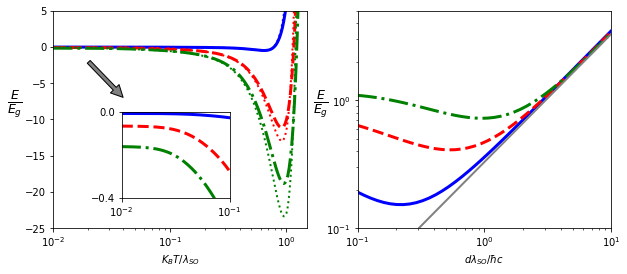

In [186]:
kbT1 = np.logspace(-2,np.log10(2),50)
a = np.logspace(-1,1,40)

E1 = np.load(os.path.join(path_casimir, 'a=10G=0Ez=1.0L=0EB=1mu=0.5.npy'))
E2 = np.load(os.path.join(path_casimir, 'a=10G=0Ez=1.0L=0EB=1mu=1.25.npy'))
E3 = np.load(os.path.join(path_casimir, 'a=10G=0Ez=1.0L=0EB=1mu=1.5.npy'))
E1a = np.zeros(kbT1.size)
E2a = np.copy(E1a)
E3a = np.copy(E1a)
for i in range(0,kbT1.size):
    E1a[i] = (ETCC(10,1.0,0,1,round(kbT1[i],4),0.5) +  ET00(10,1.0,0,1,round(kbT1[i],4),0.5))
    E2a[i] = (ETCC(10,1.0,0,1,round(kbT1[i],4),1.25) +  ET00(10,1.0,0,1,round(kbT1[i],4),1.25))
    E3a[i] = (ETCC(10,1.0,0,1,round(kbT1[i],4),1.5) +  ET00(10,1.0,0,1,round(kbT1[i],4),1.5))

kbT1interp = np.logspace(-2,np.log10(2),200)
E1 = interp1d(kbT1,E1,kind='quadratic')(kbT1interp)
E2 = interp1d(kbT1,E2,kind='quadratic')(kbT1interp)
E3 = interp1d(kbT1,E3,kind='quadratic')(kbT1interp)
E1a = interp1d(kbT1,E1a,kind='quadratic')(kbT1interp)
E2a = interp1d(kbT1,E2a,kind='quadratic')(kbT1interp)
E3a = interp1d(kbT1,E3a,kind='quadratic')(kbT1interp)
    
E4 = np.load(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0.001mu=0.5.npy'))
E5 = np.load(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0.001mu=1.25.npy'))
E6 =np.load(os.path.join(path_casimir, 'G=0.01Ez=1.0L=0EB=1T=0.001mu=1.5.npy'))
E456a = np.zeros(a.size)
for i in range(0,a.size):
    E456a[i] = EGamma(a[i],0.001)
    
#plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(figsize=(10, 4),nrows=1, ncols=2)

p00 = ax[0].semilogx(kbT1interp, E1,color='blue',linewidth=3)
p01 = ax[0].semilogx(kbT1interp, E2,color='red',linewidth=3,linestyle='dashed')
p02 = ax[0].semilogx(kbT1interp, E3,color='green',linewidth=3,linestyle='dashdot')
p03 = ax[0].semilogx(kbT1interp, E1a,color='blue',linewidth=2,linestyle='dotted')
p04 = ax[0].semilogx(kbT1interp, E2a,color='red',linewidth=2,linestyle='dotted')
p05 = ax[0].semilogx(kbT1interp, E3a,color='green',linewidth=2,linestyle='dotted')
ax[0].set_xlabel('$K_BT/\lambda_{SO}$')
ax[0].set_ylabel(r'$\frac{E}{E_g}$',rotation=0,fontsize=18,labelpad=10)
ax[0].set_xlim(0.01,1.5)
ax[0].set_ylim(-25,5)

inset = fig.add_axes([0.22,0.23,0.15,0.3])
p06 = inset.semilogx(kbT1interp, E1,color='blue',linewidth=3,subsx=[0.02])
p07 = inset.semilogx(kbT1interp, E2,color='red',linewidth=3,linestyle='dashed')
p08 = inset.semilogx(kbT1interp, E3,color='green',linewidth=3,linestyle='dashdot')
#inset.set_xlabel('$K_BT/\lambda_{SO}$',labelpad=-10)
#inset.set_ylabel(r'$\frac{E}{E_g}$',rotation=0,fontsize=14,labelpad=-20)
inset.set_xlim(0.01,0.1)
inset.set_ylim(-0.4,0)
inset.set_xticks([0.01,0.1])
inset.set_yticks([-0.4,0])
inset.minorticks_off()
ax[0].annotate('',
            xy=(0.04, -7), xycoords='data',
            xytext=(0.02, -2), textcoords='data',
            arrowprops=dict(facecolor='gray', shrink=0.01),
            horizontalalignment='right', verticalalignment='top')

p10 = ax[1].loglog(a, E4,color='blue',linewidth=3)
p11 = ax[1].loglog(a, E5,color='red',linewidth=3,linestyle='dashed')
p12 = ax[1].loglog(a, E6,color='green',linewidth=3,linestyle='dashdot')
p13 = ax[1].loglog(a, E456a,color='gray',linewidth=2)
ax[1].set_xlabel('$d\lambda_{SO}/\hbar c$')
ax[1].set_ylabel(r'$\frac{E}{E_g}$',rotation=0,fontsize=18,labelpad=5)
ax[1].set_xlim(0.1,10)
ax[1].set_ylim(0.1,5)

plt.show()

zero dissipation = strong repulsion even at room temperature.

non-zero dissipation = repulsion does not appear for T > 1K and B ~ T.